## Load datasets

In [45]:
"""BERT model for Question Answering (span extraction).
    This module is composed of the BERT model with a linear layer on top of
    the sequence output that computes start_logits and end_logits

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `start_positions`: position of the first token for the labeled span: torch.LongTensor of shape [batch_size].
            Positions are clamped to the length of the sequence and position outside of the sequence are not taken
            into account for computing the loss.
        `end_positions`: position of the last token for the labeled span: torch.LongTensor of shape [batch_size].
            Positions are clamped to the length of the sequence and position outside of the sequence are not taken
            into account for computing the loss.

    Outputs:
        if `start_positions` and `end_positions` are not `None`:
            Outputs the total_loss which is the sum of the CrossEntropy loss for the start and end token positions.
        if `start_positions` or `end_positions` is `None`:
            Outputs a tuple of start_logits, end_logits which are the logits respectively for the start and end
            position tokens of shape [batch_size, sequence_length].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    model = BertForQuestionAnswering(config)
    start_logits, end_logits = model(input_ids, token_type_ids, input_mask)
    ```
"""

"BERT model for Question Answering (span extraction).\n    This module is composed of the BERT model with a linear layer on top of\n    the sequence output that computes start_logits and end_logits\n\n    Params:\n        `config`: a BertConfig class instance with the configuration to build a new model.\n\n    Inputs:\n        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]\n            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts\n            `extract_features.py`, `run_classifier.py` and `run_squad.py`)\n        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token\n            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to\n            a `sentence B` token (see BERT paper for more details).\n        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices\n            selec

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
import logging
import json
import math
import os
import random
import pickle
import numpy as np
import torch

from tqdm import tqdm, trange
from bert_utils.bert_utils import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import whitespace_tokenize, BasicTokenizer, BertTokenizer
from pytorch_pretrained_bert.modeling import BertForQuestionAnswering
from pytorch_pretrained_bert.optimization import BertAdam
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE

Configuration settings

In [2]:
config = {'language':'kor', 'model_config':123}

## logger settings
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

if 'kor' in config['language']:
    train_file = './datasets/squad_v1.1/train-v1.1.json'
    dev_file = './datasets/squad_v1.1/dev-v1.1.json'
elif 'eng' in config['language']:
    train_file = './datasets/korquad_v1/KorQuAD_v1.0_train.json'
    dev_file = './datasets/korquad_v1/KorQuAD_v1.0_dev.json'    

In [3]:
def read_json(file_name):
    print("reading {}".format(file_name))
    with open(file_name, "r", encoding='utf-8') as reader:
        # >> type(input_data) -> list
        input_data = json.load(reader)["data"]
    print("success to read {}".format(file_name))
    return input_data

In [4]:
input_data = read_json(train_file)

reading ./datasets/squad_v1.1/train-v1.1.json
success to read ./datasets/squad_v1.1/train-v1.1.json


explore the datasets

In [5]:
type(input_data), type(input_data[0]), input_data[0].keys(), type(input_data[0]['paragraphs'])

(list, dict, dict_keys(['title', 'paragraphs']), list)

In [6]:
input_data[1]['paragraphs'][1]

{'context': 'Following the disbandment of Destiny\'s Child in June 2005, she released her second solo album, B\'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006), and starring roles in The Pink Panther (2006) and Obsessed (2009). Her marriage to rapper Jay Z and portrayal of Etta James in Cadillac Records (2008) influenced her third album, I Am... Sasha Fierce (2008), which saw the birth of her alter-ego Sasha Fierce and earned a record-setting six Grammy Awards in 2010, including Song of the Year for "Single Ladies (Put a Ring on It)". Beyoncé took a hiatus from music in 2010 and took over management of her career; her fourth album 4 (2011) was subsequently mellower in tone, exploring 1970s funk, 1980s pop, and 1990s soul. Her critically acclaimed fifth studio album, Beyoncé (2013), was distinguished from previous releases by its experimental production an

## parse datasets

In [7]:
class SquadExample(object):
    """A single training/test example for the Squad dataset."""

    def __init__(self,
                 qas_id,
                 question_text,
                 doc_tokens,
                 orig_answer_text=None,
                 start_position=None,
                 end_position=None):
        self.qas_id = qas_id
        self.question_text = question_text
        self.doc_tokens = doc_tokens
        self.orig_answer_text = orig_answer_text
        self.start_position = start_position
        self.end_position = end_position

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        s = ""
        s += "qas_id: %s" % (self.qas_id)
        s += "\n\n, question_text: %s" % (
            self.question_text)
        s += "\n\n, orig_answer_text: %s" % (
            self.orig_answer_text)
        s += "\n\n, doc_tokens: [%s]" % (" ".join(self.doc_tokens))
        if self.start_position:
            s += "\n\n, start_position: %d" % (self.start_position)
        if self.start_position:
            s += "\n\n, end_position: %d" % (self.end_position)
        return s

In [8]:
#실습 자료

In [9]:
def is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

def parse_json_squad(input_data, is_train):
    """Read a SQuAD json file into a list of SquadExample."""
    examples = list()
    for data_entry in input_data:
        for paragraph in data_entry['paragraphs']:
            paragraph_text = paragraph["context"]
            doc_tokens = []
            char_to_word_offset = []
            prev_is_whitespace = True

            # Q1. doc_tokens에 whitespace(c)를 가지고 context를 토큰화하는 코드를 작성하세요.
            ###################################################################################################
            for char in paragraph_text:
                if is_whitespace(char):
                    prev_is_whitespace = True
                else:
                    if prev_is_whitespace:
                        doc_tokens.append(char)
                    else:
                        doc_tokens[-1] += char
                    prev_is_whitespace = False
                char_to_word_offset.append(len(doc_tokens) - 1)  # Which word is the character in?
            ###################################################################################################
    
            for qa in paragraph["qas"]:
                """
                {'answers': [{'answer_start', 'text'}], 'question', 'id'}
                """
                qas_id = qa["id"]
                question_text = qa["question"]
                start_position = None
                end_position = None
                orig_answer_text = None

                if is_train:
                    if len(qa["answers"]) != 1:
                        raise ValueError(
                            "For training, each question should have exactly 1 answer.")
                    
                    # Q2. Line 34의 변수를 참고하여 Line 70: SquadExample의 instance를 만들기 위한 파라미터를 채우세요.  
                    ###################################################################################################
                    qas_id = qa["id"]     # fill the black -> assign None
                    question_text = qa["question"] # fill the black # index of word
                    answer = qa["answers"][0]
                    orig_answer_text = answer["text"]
                    answer_offset = answer["answer_start"]
                    answer_length = len(orig_answer_text)
                    start_position = char_to_word_offset[answer_offset] # index of word
                    end_position = char_to_word_offset[answer_offset + answer_length - 1] # index of word
                    ###################################################################################################

                    # CODE FOR Handling exceptions 
                    # Only add answers where the text can be exactly recovered from the
                    # document. If this CAN'T happen it's likely due to weird Unicode
                    # stuff so we will just skip the example.
                    #
                    # Note that this means for training mode, every example is NOT
                    # guaranteed to be preserved.
                    actual_text = " ".join(doc_tokens[start_position:(end_position + 1)])
                    cleaned_answer_text = " ".join(whitespace_tokenize(
                        orig_answer_text))  # segment words from the sentense including the white space
                    if actual_text.find(cleaned_answer_text) == -1:
                        logger.warning("Could not find answer: '%s' vs. '%s'",
                                       actual_text, cleaned_answer_text)
                        continue

                example = SquadExample(
                    qas_id=qas_id,
                    question_text=question_text,
                    doc_tokens=doc_tokens,  # a set of tokens(words) in the
                    orig_answer_text=orig_answer_text,
                    start_position=start_position,
                    end_position=end_position)
                examples.append(example)
    print("success to convert input data into a set of {} examples".format(len(examples)))
    return examples

In [10]:
train_examples = parse_json_squad(input_data, True)
## len of examples 87599

success to convert input data into a set of 87599 examples


In [11]:
print(train_examples[0])

qas_id: 5733be284776f41900661182

, question_text: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

, orig_answer_text: Saint Bernadette Soubirous

, doc_tokens: [Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.]

, start_position: 90

, end_position: 92


## Extract Feature

In [12]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self,
                 unique_id,
                 example_index,
                 doc_span_index,
                 tokens,
                 token_to_orig_map,
                 token_is_max_context,
                 input_ids,
                 input_mask,
                 segment_ids,
                 start_position=None,
                 end_position=None):
        
        self.unique_id = unique_id
        self.example_index = example_index
        self.doc_span_index = doc_span_index
        self.tokens = tokens
        self.token_to_orig_map = token_to_orig_map
        self.token_is_max_context = token_is_max_context
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.start_position = start_position
        self.end_position = end_position

In [13]:
def convert_examples_to_features(examples, tokenizer, max_seq_length,
                                 doc_stride, max_query_length, is_training):
    """Loads a data file into a list of `InputBatch`s."""

    unique_id = 1000000000

    features = []
    
    for (example_index, example) in enumerate(examples):
        
        # Q3. Pretrained model을 학습하는데 사용한 Tokenizer를 사용하여 question과 context의 token을 sub-token으로 토큰화해주세요.  
        ###################################################################################################
        query_tokens = tokenizer.tokenize(example.question_text)
        if len(query_tokens) > max_query_length:
            query_tokens = query_tokens[0:max_query_length]
            
        tok_to_orig_index = []
        orig_to_tok_index = []
        all_doc_tokens = []     
        for (i, token) in enumerate(example.doc_tokens):
            orig_to_tok_index.append(len(all_doc_tokens))
            sub_tokens = tokenizer.tokenize(token)
            for sub_token in sub_tokens: 
                tok_to_orig_index.append(i)                  
                all_doc_tokens.append(sub_token)
        ###################################################################################################

                
        # Q4. sub-tokens에 맞추어 span을 업데이트 해주세요.
        ###################################################################################################
        tok_start_position = None
        tok_end_position = None
        if is_training:
            tok_start_position = orig_to_tok_index[example.start_position]
            if example.end_position < len(example.doc_tokens) - 1:
                tok_end_position = orig_to_tok_index[example.end_position + 1] - 1
            else:
                tok_end_position = len(all_doc_tokens) - 1
            (tok_start_position, tok_end_position) = _improve_answer_span(
                all_doc_tokens, tok_start_position, tok_end_position, tokenizer,
                example.orig_answer_text)
        ####################################################################################################
        
        # The -3 accounts for [CLS], [SEP] and [SEP]
        max_tokens_for_doc = max_seq_length - len(query_tokens) - 3

        # doc_tokens가 설정한 max length를 넘는다면, 몇개의 DocSpan으로 쪼개야 합니다.
        # We can have documents that are longer than the maximum sequence length.
        # To deal with this we do a sliding window approach, where we take chunks
        # of the up to our max length with a stride of `doc_stride`.
        _DocSpan = collections.namedtuple(  # pylint: disable=invalid-name
            "DocSpan", ["start", "length"])
        doc_spans = []
        start_offset = 0
        while start_offset < len(all_doc_tokens):
            length = len(all_doc_tokens) - start_offset # 남은 길이
            if length > max_tokens_for_doc:
                length = max_tokens_for_doc
            doc_spans.append(_DocSpan(start=start_offset, length=length))
            if start_offset + length == len(all_doc_tokens):
                break
            start_offset += min(length, doc_stride)
            
            
        for (doc_span_index, doc_span) in enumerate(doc_spans):
            tokens = [] # input data
            segment_ids = [] # segment data
            token_to_orig_map = {}
            token_is_max_context = {}

            # Q5. query를 pretrained BERT의 입력값(features) 형식에 따라 바꿔주세요.
              # tokens -> [CLS] question [SEP] context [SEP]
              # segment_ids -> 00000000000000000000 1111111111111
            ###################################################################################################            
            tokens.append("[CLS]")
            segment_ids.append(0)
            for token in query_tokens:
                tokens.append(token)
                segment_ids.append(0)
            tokens.append("[SEP]")
            segment_ids.append(0)
            ###################################################################################################

                
            # Q6. context를 pretrained BERT의 입력값(features) 형식에 따라 바꿔주세요.
            ###################################################################################################
            for i in range(doc_span.length):
                split_token_index = doc_span.start + i
                token_to_orig_map[len(tokens)] = tok_to_orig_index[split_token_index]
                is_max_context = _check_is_max_context(doc_spans,doc_span_index,split_token_index)
                token_is_max_context[len(tokens)] = is_max_context
                tokens.append(all_doc_tokens[split_token_index])
                segment_ids.append(1) # segment ids 12 means the context
            tokens.append("[SEP]")
            segment_ids.append(1)
            ###################################################################################################
            
            # convert into the index of emmeding matrix
            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # Q7. pretrained BERT의 입력값 크기에 맞게 zero-padding 해주세요.
            ###################################################################################################
            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)
            while len(input_ids) < max_seq_length:
                input_ids.append(0)
                input_mask.append(0)
                segment_ids.append(0)

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length
            ###################################################################################################
            
            start_position = None
            end_position = None
            if is_training:
                # For training, if our document chunk does not contain an annotation
                # we throw it out, since there is nothing to predict.
                doc_start = doc_span.start
                doc_end = doc_span.start + doc_span.length - 1
                if (example.start_position < doc_start or
                        example.end_position < doc_start or
                        example.start_position > doc_end or example.end_position > doc_end):
                    continue # -> next to the DocSpan 

                doc_offset = len(query_tokens) + 2
                start_position = tok_start_position - doc_start + doc_offset
                end_position = tok_end_position - doc_start + doc_offset

            if example_index < 20:
                logger.info("*** Example ***")
                logger.info("unique_id: %s" % (unique_id))
                logger.info("example_index: %s" % (example_index))
                logger.info("doc_span_index: %s" % (doc_span_index))
                logger.info("tokens: %s" % " ".join(tokens))
                logger.info("token_to_orig_map: %s" % " ".join([
                    "%d:%d" % (x, y) for (x, y) in token_to_orig_map.items()]))
                logger.info("token_is_max_context: %s" % " ".join([
                    "%d:%s" % (x, y) for (x, y) in token_is_max_context.items()
                ]))
                logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
                logger.info(
                    "input_mask: %s" % " ".join([str(x) for x in input_mask]))
                logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
                if is_training:
                    answer_text = " ".join(tokens[start_position:(end_position + 1)])
                    logger.info("start_position: %d" % (start_position))
                    logger.info("end_position: %d" % (end_position))
                    logger.info(
                        "answer: %s" % (answer_text))
                    
            features.append(
                InputFeatures(
                    unique_id=unique_id,
                    example_index=example_index,
                    doc_span_index=doc_span_index,
                    tokens=tokens,
                    token_to_orig_map=token_to_orig_map,
                    token_is_max_context=token_is_max_context,
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    start_position=start_position,
                    end_position=end_position))
            unique_id += 1

    return features

## Wrap the train_features in a `Dataloader`

In [14]:
config='bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(config)
max_seq_length=128
doc_stride=128
max_query_length=64
cached_train_features_file = train_file+'_{0}_{1}_{2}'.format(config, str(max_seq_length), str(doc_stride))

train_batch_size=15
predict_batch_size=15
num_train_epochs=2
gradient_accumulation_steps=1
warmup_proportion=0.1
learning_rate=5e-5
num_train_steps = int(num_train_epochs * len(train_examples) / train_batch_size) #  /gradient_accumulation_steps *num_train_epochs

08/11/2020 00:53:57 - WARNING - pytorch_pretrained_bert.tokenization -   The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.
08/11/2020 00:53:58 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /home/daehoon/.pytorch_pretrained_bert/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729


In [15]:
try:
    with open(cached_train_features_file, "rb") as reader:
        train_features = pickle.load(reader)
except:
    train_features = convert_examples_to_features(
        examples=train_examples,
        tokenizer=tokenizer,
        max_seq_length=max_seq_length,
        doc_stride=doc_stride,
        max_query_length=max_query_length,
        is_training=True)
    print('finish extracting the features from the examples')
    logger.info("  Saving train features into cached file %s", cached_train_features_file)
    with open(cached_train_features_file, "wb") as writer:
        pickle.dump(train_features, writer)

In [19]:
print(train_features[0].tokens)
print(tokenizer.convert_tokens_to_ids(train_features[0].tokens))

['[CLS]', 'To', 'whom', 'did', 'the', 'Virgin', 'Mary', 'allegedly', 'appear', 'in', '1858', 'in', 'Lourdes', 'France', '?', '[SEP]', 'Arch', '##ite', '##ctural', '##ly', ',', 'the', 'school', 'has', 'a', 'Catholic', 'character', '.', 'At', '##op', 'the', 'Main', 'Building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'Virgin', 'Mary', '.', 'Im', '##mediate', '##ly', 'in', 'front', 'of', 'the', 'Main', 'Building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'Christ', 'with', 'arms', 'up', '##rais', '##ed', 'with', 'the', 'legend', '"', 'Ve', '##nite', 'Ad', 'Me', 'Om', '##nes', '"', '.', 'Next', 'to', 'the', 'Main', 'Building', 'is', 'the', 'Basilica', 'of', 'the', 'Sacred', 'Heart', '.', 'Im', '##mediate', '##ly', 'behind', 'the', 'basilica', 'is', 'the', 'G', '##rott', '##o', ',', 'a', 'Marian', 'place', 'of', 'prayer', 'and', 'reflect', '##ion', '.', 'It', 'is', 'a', 'replica', 'of', 'the', 'gr', '##otto', 'at', 'Lourdes', ',', '[SEP]']

In [32]:
logger.info("***** Running training *****")
logger.info("  Num orig examples = %d", len(train_examples))
logger.info("  Num split examples = %d", len(train_features))
logger.info("  Batch size = %d", train_batch_size)
logger.info("  Num steps = %d", num_train_steps)

all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long) ## must be long type
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_start_positions = torch.tensor([f.start_position for f in train_features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in train_features], dtype=torch.long)
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_start_positions, all_end_positions)
                           
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

08/10/2020 02:55:04 - INFO - __main__ -   ***** Running training *****
08/10/2020 02:55:04 - INFO - __main__ -     Num orig examples = 87599
08/10/2020 02:55:04 - INFO - __main__ -     Num split examples = 87056
08/10/2020 02:55:04 - INFO - __main__ -     Batch size = 15
08/10/2020 02:55:04 - INFO - __main__ -     Num steps = 11679


## Model Settings

In [35]:
model = BertForQuestionAnswering.from_pretrained(config)
local_rank = -1
gpu_num =2
device = torch.device(f"cuda:{gpu_num}")
t_total = num_train_steps
model.to(device)  # [2] TITAN Xp         | 43'C,   0 % |  1235 / 12196 MB | gyuhyeon(1223M)

08/10/2020 03:07:27 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased.tar.gz from cache at /home/daehoon/.pytorch_pretrained_bert/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9
08/10/2020 03:07:27 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/daehoon/.pytorch_pretrained_bert/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9 to temp dir /tmp/tmpl05y8eir
08/10/2020 03:07:35 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hi

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
       

In [36]:
t_total = num_train_steps
param_optimizer = list(model.named_parameters())

# hack to remove pooler, which is not used
# thus it produce None grad that break apex
param_optimizer = [n for n in param_optimizer if 'pooler' not in n[0]]  # remove the first class label('pooler')

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

t_total = num_train_steps

# find BertAdam in the https://huggingface.co/transformers/migration.html
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=learning_rate,
                     warmup=warmup_proportion,
                     t_total=t_total)

In [37]:
global_step = 0
model.train()
# Q8. Pretrained BERT를 fine tuning하는 training 코드를 채워주세요.
###################################################################################################
# [2] TITAN Xp         | 61'C,  65 % |  6757 / 12196 MB | gyuhyeon(6745M)
for _ in trange(int(num_train_epochs), desc="Epoch"):
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = [b.to(device) for b in batch]  # to cuda
        input_ids, input_mask, segment_ids, start_positions, end_positions = batch
        loss = model(input_ids, segment_ids, input_mask, start_positions, end_positions)
        #if n_gpu > 1:
        #    loss = loss.mean() # mean() to average on multi-gpu.
        loss.backward()
        
        """
        Added Explaination for the Below Code
        f your data set is highly differentiated, you can suffer from a sort of "early over-fitting". 
        If your shuffled data happens to include a cluster of related, strongly-featured observations,
        your model's initial training can skew badly toward those features -- or worse,
        toward incidental features that aren't truly related to the topic at all.

        Warm-up is a way to reduce the primacy effect of the early training examples.
        Without it, you may need to run a few extra epochs to get the convergence desired,
        as the model un-trains those early superstitions.
        """
        lr_this_step = learning_rate * warmup_linear(global_step/t_total, warmup_proportion)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_this_step
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
###################################################################################################

Iteration:   0%|          | 0/5804 [00:00<?, ?it/s]/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)

Iteration:   4%|▍         | 247/5804 [01:17<29:20,  3.16it/s]


Iteration:   9%|▊         | 499/5804 [02:37<28:48,  3.07it/s]


Iteration:  13%|█▎        | 751/5804 [03:57<25:46,  3.27it/s]


Iteration:  17%|█▋        | 1002/5804 [05:17<26:25,  3.03it/s]


Iteration:  22%|██▏       | 1250/5804 [06:36<24:52,  3.05it/s]


Iteration:  26%|██▌       | 1498/5804 [07:54<23:23,  3.07it/s]


Iteration:  30%|███       | 1746/5804 [09:13<20:47,  3.25it/s]


Iteration:  34%|███▍      | 1994/5804 [10:32<20:18,  3.13it/s]


Iteration:  39%|███▊      | 2242/5804 [11:50<18:45,  3.16it/s]


Iteration:  43%|████▎     | 2490/5804 [13:09<17:42,  3.12it/s]


Iteration:  47%|████▋     | 2738/5804 [14:27<16:51,  3.03it/s]


Iteration:  51%|█████▏    | 2986/5804 [15:45<15:08,  3.10it/s]


Iteration:  56%|█████▌    | 3234/5804 [17:04<13:09,  3.25it/s]


Iteration:  60%|█████▉    | 3482/5804 [18:23<12:09,  3.19it/s]


Iteration:  64%|██████▍   | 3730/5804 [19:42<10:38,  3.25it/s]


Iteration:  69%|██████▊   | 3978/5804 [21:00<09:32,  3.19it/s]


Iteration:  73%|███████▎  | 4226/5804 [22:18<08:39,  3.04it/s]


Iteration:  77%|███████▋  | 4474/5804 [23:36<07:10,  3.09it/s]


Iteration:  81%|████████▏ | 4722/5804 [24:55<05:47,  3.12it/s]


Iteration:  86%|████████▌ | 4970/5804 [26:14<04:17,  3.24it/s]


Iteration:  90%|████████▉ | 5218/5804 [27:33<03:05,  3.15it/s]


Iteration:  94%|█████████▍| 5466/5804 [28:51<01:43,  3.27it/s]


Iteration:  98%|█████████▊| 5714/5804 [30:09<00:28,  3.15it/s]


Iteration:   3%|▎         | 160/5804 [00:49<29:03,  3.24it/s]


Iteration:   7%|▋         | 412/5804 [02:08<28:15,  3.18it/s]


Iteration:  11%|█▏        | 664/5804 [03:28<27:42,  3.09it/s]


Iteration:  16%|█▌        | 916/5804 [04:48<25:22,  3.21it/s]


Iteration:  20%|██        | 1165/5804 [06:07<25:25,  3.04it/s]


Iteration:  24%|██▍       | 1413/5804 [07:26<22:27,  3.26it/s]


Iteration:  29%|██▊       | 1661/5804 [08:45<22:25,  3.08it/s]


Iteration:  33%|███▎      | 1909/5804 [10:05<21:00,  3.09it/s]


Iteration:  37%|███▋      | 2157/5804 [11:24<19:33,  3.11it/s]


Iteration:  41%|████▏     | 2405/5804 [12:43<18:20,  3.09it/s]


Iteration:  46%|████▌     | 2653/5804 [14:02<17:20,  3.03it/s]


Iteration:  50%|████▉     | 2901/5804 [15:21<15:41,  3.08it/s]


Iteration:  54%|█████▍    | 3149/5804 [16:39<13:37,  3.25it/s]


Iteration:  59%|█████▊    | 3397/5804 [17:57<12:18,  3.26it/s]


Iteration:  63%|██████▎   | 3645/5804 [19:15<11:04,  3.25it/s]


Iteration:  67%|██████▋   | 3893/5804 [20:31<10:16,  3.10it/s]


Iteration:  71%|███████▏  | 4141/5804 [21:48<08:29,  3.26it/s]


Iteration:  76%|███████▌  | 4389/5804 [23:05<07:12,  3.27it/s]


Iteration:  80%|███████▉  | 4637/5804 [24:23<06:07,  3.18it/s]


Iteration:  84%|████████▍ | 4885/5804 [25:41<05:00,  3.06it/s]


Iteration:  88%|████████▊ | 5133/5804 [26:58<03:24,  3.28it/s]


Iteration:  93%|█████████▎| 5381/5804 [28:16<02:09,  3.26it/s]


Iteration:  97%|█████████▋| 5629/5804 [29:36<00:56,  3.09it/s]


Epoch: 100%|██████████| 2/2 [1:01:10<00:00, 1835.11s/it]


## Model Save

In [40]:
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
# output_model_file = os.path.join("/Model", "pytorch_model.bin")
torch.save(model_to_save.state_dict(), "./save/models/squad_finetuned_bert_128_epochs_2.bin")

os.listdir('./save/models')

"""
torch.save({"model_type": self.model_type,
            "start_epoch": epoch + 1,
            "network": self.net.state_dict(),
            "optimizer": self.optim.state_dict(),
            "best_metric": self.best_metric,
            }, str(save_path) + "/%s.pth.tar" % (filename))

## how to load            
self.net.load_state_dict(ckpoint['network'])
self.optim.load_state_dict(ckpoint['optimizer'])
self.start_epoch = ckpoint['start_epoch']
self.best_metric = ckpoint["best_metric"]
"""

['squad_finetuned_bert_128_epochs_2.bin']

## Model load

In [31]:
gpu_num =2
device = torch.device(f"cuda:{gpu_num}")

config = 'bert-base-multilingual-cased'
model = BertForQuestionAnswering.from_pretrained(config)
tokenizer = BertTokenizer.from_pretrained(config)

saving_point = torch.load("./save/models/squad_finetuned_bert_128_epochs_2.bin")
model.load_state_dict(saving_point)
model.to(device)

08/10/2020 04:57:24 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased.tar.gz from cache at /home/daehoon/.pytorch_pretrained_bert/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9
08/10/2020 04:57:24 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/daehoon/.pytorch_pretrained_bert/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9 to temp dir /tmp/tmp00jklsnf
08/10/2020 04:57:32 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hi

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
       

In [33]:
max_seq_length=128
doc_stride=128
max_query_length=64
predict_batch_size=50
input_data = read_json(dev_file)
eval_examples = parse_json_squad(
    input_data=input_data, is_train=False)
eval_features = convert_examples_to_features(
    examples=eval_examples,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    doc_stride=doc_stride,
    max_query_length=max_query_length,
    is_training=False)

logger.info("***** Running predictions *****")
logger.info("  Num orig examples = %d", len(eval_examples))
logger.info("  Num split examples = %d", len(eval_features))
logger.info("  Batch size = %d",predict_batch_size)

all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_example_index)

# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=predict_batch_size)

reading ./datasets/squad_v1.1/dev-v1.1.json
success to read ./datasets/squad_v1.1/dev-v1.1.json


08/10/2020 04:58:11 - INFO - __main__ -   *** Example ***
08/10/2020 04:58:11 - INFO - __main__ -   unique_id: 1000000000
08/10/2020 04:58:11 - INFO - __main__ -   example_index: 0
08/10/2020 04:58:11 - INFO - __main__ -   doc_span_index: 0
08/10/2020 04:58:11 - INFO - __main__ -   tokens: [CLS] W ##hic ##h NFL team represented the AFC at Super Bowl 50 ? [SEP] Super Bowl 50 was an American football game to determine the champion of the National Football League ( NFL ) for the 2015 season . The American Football Conference ( AFC ) champion Denver Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers 24 [UNK] 10 to earn their third Super Bowl title . The game was played on February 7 , 2016 , at Levi ' s Stadium in the San Francisco Bay Area at Santa Clara , California . As this was the 50th Super Bowl , the league em ##pha ##sized the " golden anniversary " with various gold - theme ##d initiatives , as well [SEP]
08/10/2020 04:58:11 - INFO - __main__ -   

08/10/2020 04:58:11 - INFO - __main__ -   token_is_max_context: 15:True 16:True 17:True 18:True 19:True 20:True 21:True 22:True 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31:True 32:True 33:True 34:True 35:True 36:True 37:True 38:True 39:True 40:True 41:True 42:True 43:True 44:True 45:True 46:True 47:True 48:True 49:True 50:True 51:True 52:True 53:True 54:True 55:True 56:True 57:True 58:True 59:True 60:True 61:True 62:True 63:True 64:True 65:True 66:True 67:True 68:True 69:True 70:True 71:True 72:True 73:True 74:True 75:True 76:True 77:True 78:True 79:True 80:True 81:True 82:True 83:True 84:True 85:True 86:True 87:True 88:True 89:True 90:True 91:True 92:True 93:True 94:True 95:True 96:True 97:True 98:True 99:True 100:True 101:True 102:True 103:True 104:True 105:True 106:True 107:True 108:True 109:True 110:True 111:True 112:True 113:True 114:True 115:True 116:True 117:True 118:True 119:True 120:True 121:True 122:True 123:True 124:True 125:True 126:True
08/10/2020 04

08/10/2020 04:58:11 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
08/10/2020 04:58:11 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
08/10/2020 04:58:11 - INFO - __main__ -   *** Example ***
08/10/2020 04:58:11 - INFO - __main__ -   unique_id: 1000000005
08/10/2020 04:58:11 - INFO - __main__ -   example_index: 2
08/10/2020 04:58:11 - INFO - __main__ -   doc_span_index: 1
08/10/2020 04:58:11 - INFO - __main__ -   tokens: [CLS] Where did Super Bowl 50 take place ? [SEP] the tradition of naming each Super Bowl

08/10/2020 04:58:11 - INFO - __main__ -   input_ids: 101 160 39187 10237 20179 11121 11367 12786 23010 10462 136 102 63592 10230 10105 20049 10108 90742 11948 12786 23010 11661 10169 12359 76274 11747 113 10571 10319 10105 11661 10894 10529 10590 11053 10146 107 12786 23010 149 107 114 117 10380 10189 10105 18655 12174 22861 10454 19072 10105 26571 76274 11747 10462 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/10/2020 04:58:11 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/10/2020 04:58:11 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 

08/10/2020 04:58:11 - INFO - __main__ -   token_to_orig_map: 11:0 12:1 13:2 14:3 15:4 16:5 17:6 18:7 19:8 20:9 21:10 22:11 23:12 24:13 25:14 26:15 27:16 28:17 29:17 30:17 31:18 32:19 33:20 34:21 35:21 36:22 37:23 38:24 39:25 40:26 41:26 42:26 43:27 44:28 45:29 46:30 47:31 48:32 49:33 50:34 51:35 52:35 53:35 54:36 55:37 56:38 57:39 58:39 59:39 60:40 61:41 62:42 63:43 64:44 65:45 66:46 67:46 68:47 69:48 70:49 71:50 72:51 73:52 74:53 75:53 76:54 77:54 78:55 79:56 80:56 81:56 82:57 83:58 84:59 85:60 86:61 87:62 88:63 89:64 90:65 91:66 92:66 93:67 94:67 95:68 96:69 97:70 98:71 99:72 100:73 101:74 102:74 103:75 104:76 105:77 106:77 107:77 108:78 109:79 110:79 111:80 112:80 113:81 114:82 115:83 116:83 117:83 118:83 119:84 120:84 121:85 122:86 123:87 124:88 125:89 126:89
08/10/2020 04:58:11 - INFO - __main__ -   token_is_max_context: 11:True 12:True 13:True 14:True 15:True 16:True 17:True 18:True 19:True 20:True 21:True 22:True 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31

08/10/2020 04:58:11 - INFO - __main__ -   input_ids: 101 12489 11940 10134 10105 11661 11553 10135 136 102 12786 23010 10462 10134 10151 10536 12485 11661 10114 37284 10105 17689 10108 10105 10655 12499 11074 113 20179 114 10142 10105 10222 11226 119 10117 10536 12499 16424 113 26523 114 17689 29357 87078 18058 10105 10655 12499 16424 113 80893 114 17689 14329 69440 10233 100 10150 10114 65065 10455 12628 12786 23010 12887 119 10117 11661 10134 11553 10135 11508 128 117 10255 117 10160 33875 112 187 16632 10106 10105 10469 11798 13146 17815 10160 11154 23086 117 11621 119 10882 10531 10134 10105 98105 12786 23010 117 10105 15616 10266 37590 109461 10105 107 52477 37157 107 10169 13547 18128 118 26648 10162 82311 117 10146 11206 10146 69175 10846 63592 10230 102
08/10/2020 04:58:11 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

08/10/2020 04:58:11 - INFO - __main__ -   tokens: [CLS] What is the AFC short for ? [SEP] tradition of naming each Super Bowl game with Roman numera ##ls ( under which the game would have been known as " Super Bowl L " ) , so that the logo could prominent ##ly feature the Arabic numera ##ls 50 . [SEP]
08/10/2020 04:58:11 - INFO - __main__ -   token_to_orig_map: 9:91 10:92 11:93 12:94 13:95 14:96 15:97 16:98 17:99 18:100 19:100 20:101 21:101 22:102 23:103 24:104 25:105 26:106 27:107 28:108 29:109 30:110 31:110 32:111 33:112 34:112 35:112 36:112 37:113 38:114 39:115 40:116 41:117 42:118 43:118 44:119 45:120 46:121 47:122 48:122 49:123 50:123
08/10/2020 04:58:11 - INFO - __main__ -   token_is_max_context: 9:True 10:True 11:True 12:True 13:True 14:True 15:True 16:True 17:True 18:True 19:True 20:True 21:True 22:True 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31:True 32:True 33:True 34:True 35:True 36:True 37:True 38:True 39:True 40:True 41:True 42:True 43:True 44:True 4

08/10/2020 04:58:11 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/10/2020 04:58:11 - INFO - __main__ -   *** Example ***
08/10/2020 04:58:11 - INFO - __main__ -   unique_id: 1000000018
08/10/2020 04:58:11 - INFO - __main__ -   example_index: 9
08/10/2020 04:58:11 - INFO - __main__ -   doc_span_index: 0
08/10/2020 04:58:11 - INFO - __main__ -   tokens: [CLS] What does AFC stand for ? [SEP] Super Bowl 50 was an American football game to determine the champion of the National Football League ( NFL ) for the 2015 season . The American Football Conference ( AFC ) champion Denver Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers 24 [UNK] 10 to earn their third Super Bowl title . The game was played on February 7 ,

08/10/2020 04:58:11 - INFO - __main__ -   token_is_max_context: 11:True 12:True 13:True 14:True 15:True 16:True 17:True 18:True 19:True 20:True 21:True 22:True 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31:True 32:True 33:True 34:True 35:True 36:True 37:True 38:True 39:True 40:True 41:True 42:True 43:True 44:True 45:True 46:True 47:True 48:True 49:True 50:True 51:True 52:True 53:True 54:True 55:True 56:True 57:True 58:True 59:True 60:True 61:True 62:True 63:True 64:True 65:True 66:True 67:True 68:True 69:True 70:True 71:True 72:True 73:True 74:True 75:True 76:True 77:True 78:True 79:True 80:True 81:True 82:True 83:True 84:True 85:True 86:True 87:True 88:True 89:True 90:True 91:True 92:True 93:True 94:True 95:True 96:True 97:True 98:True 99:True 100:True 101:True 102:True 103:True 104:True 105:True 106:True 107:True 108:True 109:True 110:True 111:True 112:True 113:True 114:True 115:True 116:True 117:True 118:True 119:True 120:True 121:True 122:True 123:True 124:True

08/10/2020 04:58:11 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
08/10/2020 04:58:11 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
08/10/2020 04:58:11 - INFO - __main__ -   *** Example ***
08/10/2020 04:58:11 - INFO - __main__ -   unique_id: 1000000023
08/10/2020 04:58:11 - INFO - __main__ -   example_index: 11
08/10/2020 04:58:11 - INFO - __main__ -   doc_span_index: 1
08/10/2020 04:58:11 - INFO - __main__ -   tokens: [CLS] Who won Super Bowl 50 ? [SEP] of naming each Super Bowl game with Roman numera ##

08/10/2020 04:58:11 - INFO - __main__ -   input_ids: 101 12489 39975 12172 12786 23010 10462 13574 11192 10106 136 102 63592 10230 10105 20049 10108 90742 11948 12786 23010 11661 10169 12359 76274 11747 113 10571 10319 10105 11661 10894 10529 10590 11053 10146 107 12786 23010 149 107 114 117 10380 10189 10105 18655 12174 22861 10454 19072 10105 26571 76274 11747 10462 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/10/2020 04:58:11 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/10/2020 04:58:11 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

success to convert input data into a set of 10570 examples


08/10/2020 04:58:11 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
08/10/2020 04:58:11 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
08/10/2020 04:58:11 - INFO - __main__ -   *** Example ***
08/10/2020 04:58:11 - INFO - __main__ -   unique_id: 1000000027
08/10/2020 04:58:11 - INFO - __main__ -   example_index: 13
08/10/2020 04:58:11 - INFO - __main__ -   doc_span_index: 1
08/10/2020 04:58:11 - INFO - __main__ -   tokens: [CLS] What city did Super Bowl 50 take place in ? [SEP] ##pend ##ing the tradition of n

08/10/2020 04:58:11 - INFO - __main__ -   token_is_max_context: 18:True 19:True 20:True 21:True 22:True 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31:True 32:True 33:True 34:True 35:True 36:True 37:True 38:True 39:True 40:True 41:True 42:True 43:True 44:True 45:True 46:True 47:True 48:True 49:True 50:True 51:True 52:True 53:True 54:True 55:True 56:True 57:True 58:True 59:True 60:True 61:True 62:True 63:True 64:True 65:True 66:True 67:True 68:True
08/10/2020 04:58:11 - INFO - __main__ -   input_ids: 101 14535 12359 76274 11747 10309 11031 117 12976 10894 12786 23010 10462 10529 10590 11552 136 102 117 10146 11206 10146 69175 10846 63592 10230 10105 20049 10108 90742 11948 12786 23010 11661 10169 12359 76274 11747 113 10571 10319 10105 11661 10894 10529 10590 11053 10146 107 12786 23010 149 107 114 117 10380 10189 10105 18655 12174 22861 10454 19072 10105 26571 76274 11747 10462 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

08/10/2020 04:58:11 - INFO - __main__ -   *** Example ***
08/10/2020 04:58:11 - INFO - __main__ -   unique_id: 1000000032
08/10/2020 04:58:11 - INFO - __main__ -   example_index: 16
08/10/2020 04:58:11 - INFO - __main__ -   doc_span_index: 0
08/10/2020 04:58:11 - INFO - __main__ -   tokens: [CLS] What year did the Denver Broncos secure a Super Bowl title for the third time ? [SEP] Super Bowl 50 was an American football game to determine the champion of the National Football League ( NFL ) for the 2015 season . The American Football Conference ( AFC ) champion Denver Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers 24 [UNK] 10 to earn their third Super Bowl title . The game was played on February 7 , 2016 , at Levi ' s Stadium in the San Francisco Bay Area at Santa Clara , California . As this was the 50th Super Bowl , the league em ##pha ##sized the " golden anniversary " with various gold - theme ##d initiatives [SEP]
08/10/2020 04:58:11 - INFO - __

08/10/2020 04:58:11 - INFO - __main__ -   token_is_max_context: 12:True 13:True 14:True 15:True 16:True 17:True 18:True 19:True 20:True 21:True 22:True 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31:True 32:True 33:True 34:True 35:True 36:True 37:True 38:True 39:True 40:True 41:True 42:True 43:True 44:True 45:True 46:True 47:True 48:True 49:True 50:True 51:True 52:True 53:True 54:True 55:True 56:True 57:True 58:True 59:True 60:True 61:True 62:True 63:True 64:True 65:True 66:True 67:True 68:True 69:True 70:True 71:True 72:True 73:True 74:True 75:True 76:True 77:True 78:True 79:True 80:True 81:True 82:True 83:True 84:True 85:True 86:True 87:True 88:True 89:True 90:True 91:True 92:True 93:True 94:True 95:True 96:True 97:True 98:True 99:True 100:True 101:True 102:True 103:True 104:True 105:True 106:True 107:True 108:True 109:True 110:True 111:True 112:True 113:True 114:True 115:True 116:True 117:True 118:True 119:True 120:True 121:True 122:True 123:True 124:True 125:Tru

08/10/2020 04:58:11 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
08/10/2020 04:58:11 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
08/10/2020 04:58:11 - INFO - __main__ -   *** Example ***
08/10/2020 04:58:11 - INFO - __main__ -   unique_id: 1000000037
08/10/2020 04:58:11 - INFO - __main__ -   example_index: 18
08/10/2020 04:58:11 - INFO - __main__ -   doc_span_index: 1
08/10/2020 04:58:11 - INFO - __main__ -   tokens: [CLS] What stadium did Super Bowl 50 take place in ? [SEP] ##pend ##ing the tradition o

08/10/2020 04:58:11 - INFO - __main__ -   token_is_max_context: 12:True 13:True 14:True 15:True 16:True 17:True 18:True 19:True 20:True 21:True 22:True 23:True 24:True 25:True 26:True 27:True 28:True 29:True 30:True 31:True 32:True 33:True 34:True 35:True 36:True 37:True 38:True 39:True 40:True 41:True 42:True 43:True 44:True 45:True 46:True 47:True 48:True 49:True 50:True 51:True 52:True 53:True 54:True 55:True 56:True
08/10/2020 04:58:11 - INFO - __main__ -   input_ids: 101 12489 10134 10105 11070 17704 10108 12786 23010 10462 136 102 63592 10230 10105 20049 10108 90742 11948 12786 23010 11661 10169 12359 76274 11747 113 10571 10319 10105 11661 10894 10529 10590 11053 10146 107 12786 23010 149 107 114 117 10380 10189 10105 18655 12174 22861 10454 19072 10105 26571 76274 11747 10462 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/10/2020 04:58:11 - INFO - __main__ -   input_mask: 1 1

In [34]:
model.eval()
all_results = []
logger.info("Start evaluating")
for input_ids, input_mask, segment_ids, example_indices in tqdm(eval_dataloader, desc="Evaluating"):
    if len(all_results) % 1000 == 0:
        logger.info("Processing example: %d" % (len(all_results)))
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    with torch.no_grad():
        batch_start_logits, batch_end_logits = model(input_ids, segment_ids, input_mask)
    for i, example_index in enumerate(example_indices):
        start_logits = batch_start_logits[i].detach().cpu().tolist()
        end_logits = batch_end_logits[i].detach().cpu().tolist()
        eval_feature = eval_features[example_index.item()]
        unique_id = int(eval_feature.unique_id)
        all_results.append(RawResult(unique_id=unique_id,
                                     start_logits=start_logits,
                                     end_logits=end_logits))

08/10/2020 04:59:11 - INFO - __main__ -   Start evaluating

Evaluating:   0%|          | 0/435 [00:00<?, ?it/s]08/10/2020 04:59:11 - INFO - __main__ -   Processing example: 0

Evaluating:   5%|▍         | 20/435 [00:03<01:15,  5.46it/s]08/10/2020 04:59:14 - INFO - __main__ -   Processing example: 1000

Evaluating:   9%|▉         | 40/435 [00:07<01:12,  5.44it/s]08/10/2020 04:59:18 - INFO - __main__ -   Processing example: 2000

Evaluating:  14%|█▍        | 60/435 [00:11<01:08,  5.45it/s]08/10/2020 04:59:22 - INFO - __main__ -   Processing example: 3000

Evaluating:  18%|█▊        | 80/435 [00:14<01:06,  5.35it/s]08/10/2020 04:59:25 - INFO - __main__ -   Processing example: 4000

Evaluating:  23%|██▎       | 100/435 [00:18<01:03,  5.31it/s]08/10/2020 04:59:29 - INFO - __main__ -   Processing example: 5000

Evaluating:  28%|██▊       | 120/435 [00:22<00:58,  5.37it/s]08/10/2020 04:59:33 - INFO - __main__ -   Processing example: 6000

Evaluating:  32%|███▏      | 140/435 [00:26<00:55,  5.

Evaluating:  55%|█████▌    | 240/435 [00:45<00:39,  4.89it/s]08/10/2020 04:59:56 - INFO - __main__ -   Processing example: 12000

Evaluating:  60%|█████▉    | 260/435 [00:49<00:36,  4.85it/s]08/10/2020 05:00:00 - INFO - __main__ -   Processing example: 13000

Evaluating:  64%|██████▍   | 280/435 [00:53<00:30,  5.11it/s]08/10/2020 05:00:04 - INFO - __main__ -   Processing example: 14000

Evaluating:  69%|██████▉   | 300/435 [00:57<00:27,  4.94it/s]08/10/2020 05:00:08 - INFO - __main__ -   Processing example: 15000

Evaluating:  74%|███████▎  | 320/435 [01:01<00:21,  5.32it/s]08/10/2020 05:00:12 - INFO - __main__ -   Processing example: 16000

Evaluating:  78%|███████▊  | 340/435 [01:05<00:18,  5.23it/s]08/10/2020 05:00:16 - INFO - __main__ -   Processing example: 17000

Evaluating:  83%|████████▎ | 360/435 [01:09<00:15,  4.86it/s]08/10/2020 05:00:20 - INFO - __main__ -   Processing example: 18000

Evaluating:  87%|████████▋ | 380/435 [01:13<00:11,  4.84it/s]08/10/2020 05:00:24 - INFO - 

![nn](images/image_1.jpg)

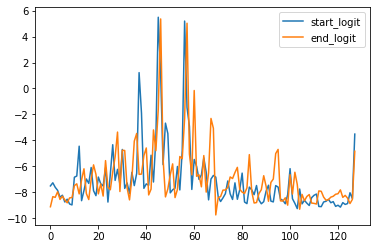

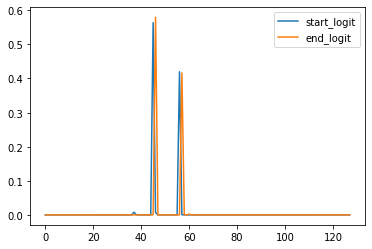

45 46


In [63]:
import matplotlib.pyplot as plt
import numpy as np

def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

start_logit = all_results[6].start_logits
end_logit = all_results[6].end_logits
index = np.arange(len(start_logit))

# berore softmax
plt.plot(index, start_logit, label='start_logit')
plt.plot(index, end_logit, label='end_logit')
plt.legend(loc='best')
plt.show()

# after softmax
plt.plot(index, softmax(start_logit), label='start_logit')
plt.plot(index, softmax(end_logit), label='end_logit')
plt.legend(loc='best')
plt.show()

pred_start_index = np.argmax(start_logit)
pred_end_index = np.argmax(end_logit)
print(np.argmax(start_logit), np.argmax(end_logit))

In [87]:
pred_start_index = np.argmax(start_logit)
pred_end_index = np.argmax(end_logit)
orig_doc_start = eval_features[6].token_to_orig_map[pred_start_index]
orig_doc_end = eval_features[6].token_to_orig_map[pred_end_index]
orig_tokens = eval_examples[eval_features[6].example_index].doc_tokens[orig_doc_start:(orig_doc_end + 1)]

print(eval_examples[eval_features[6].example_index])
print("\n\nAnswer: {}".format(" ".join(orig_tokens)))

qas_id: 56be4db0acb8001400a502ef

, question_text: Which NFL team won Super Bowl 50?

, orig_answer_text: None

, doc_tokens: [Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.]


Answer: Denver Broncos


In [69]:
output_dir='./save/predictions'
n_best_size=20
max_answer_length=30
do_lower_case=True
verbose_logging=False

output_prediction_file = os.path.join(output_dir, "squad_test_predictions.json")
output_nbest_file = os.path.join(output_dir, "nbest_squad_test_predictions.json")
all_predictions = write_predictions(eval_examples, eval_features, all_results,
                  n_best_size, max_answer_length,
                  do_lower_case, output_prediction_file,
                  output_nbest_file, verbose_logging)

08/10/2020 05:53:51 - INFO - __main__ -   Writing predictions to: ./save/predictions/squad_test_predictions.json
08/10/2020 05:53:51 - INFO - __main__ -   Writing nbest to: ./save/predictions/nbest_squad_test_predictions.json


## Get scores

In [89]:
with open('./datasets/squad_v1.1/dev-v1.1.json') as f:
    dataset_json = json.load(f)
    dataset = dataset_json['data']
with open('./save/predictions/squad_test_predictions.json') as f:
    preds = json.load(f)

In [90]:
qid_to_has_ans = make_qid_to_has_ans(dataset)  # maps qid to True/False
has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]
exact, f1 = get_raw_scores(dataset, preds)

out_eval = make_eval_dict(exact, f1)
out_eval

OrderedDict([('exact', 77.18070009460737),
             ('f1', 84.71442688086603),
             ('total', 10570)])